# lets calculate the proj-NTK of a trained ResNet18 on CIFAR10


### For our experiments, we used weights from an external copy of ResNet18: 

Permanent link to repository: https://zenodo.org/record/4431043

Otherwise, you should be able to access the weights at the original repository [here](https://github.com/huyvnphan/PyTorch_CIFAR10/tree/master) 

we've included the definition of resnet18 in utils.py as a module file, so we can import it here.

In [3]:
#Standard dependencies
import torch
from pathlib import Path
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import numpy as np
import os

#Base module
from trak import TRAKer
from trak.modelout_functions import trNTKModelOutput 

#extra dependencies
from tqdm import tqdm
from einops import rearrange

#model definition
from utils2 import resnet18

#download and preprocess Cifar10
from utils2 import process_Cifar10


### We choose to study NTK at the end of training; in principle, could compute NTK anywhere, including initialization. But for now, lets load the weights we downloaded from the repository above.

In [4]:
ckpt = torch.load('/path/to/resnet18.pt')

### Define the model as a torch.nn.Module instance

In [5]:
MODELNAME = 'ResNet18'
model = resnet18(device='cuda').to(memory_format=torch.channels_last).cuda().eval()

### Define the data we would like to compute an NTK over. Typically, you would supply a single dataloader with both training and testing data concatenated together.

In [6]:
train, test, combined = process_Cifar10('./')

train_loader = DataLoader(train,batch_size=64,shuffle=False)
test_loader = DataLoader(test,batch_size=64,shuffle=False)
#combined = concatenation[test,train]
combined_loader = DataLoader(combined,batch_size=64,shuffle=False)

### Initialize the TRAKer object

In [7]:
#where to save gradient information-- warning, can get big!
SAVEPATH = '/rcfs/projects/task0_pmml/proj_trNTK/test_quick/'

In [9]:
traker = TRAKer(model=model,
                task='pNTK', #
                save_dir = SAVEPATH, #unique save for this experiment run
                train_set_size=len(combined_loader.dataset), #length of dataloader
                proj_dim=512, #K, for cuda must be multiple of 512, we chose 512*20 for results in paper
                proj_max_batch_size=16, #choose one of [8,16,32] for cuda. affects max memory load
                use_half_precision=False) #default is True

                             Report any issues at https://github.com/MadryLab/trak/issues
INFO:STORE:No existing model IDs in /rcfs/projects/task0_pmml/proj_trNTK/test_quick.
INFO:STORE:No existing TRAK scores in /rcfs/projects/task0_pmml/proj_trNTK/test_quick.


In [10]:
# TRAKer loads the provided checkpoint and also associates
# the provided (unique) model_id with the checkpoint.
traker.load_checkpoint(ckpt, model_id=0)

for batch in tqdm(combined_loader):
    batch = [x.cuda() for x in batch]
    #technically, our trNTK and pNTK modeloutput functions do not utilize
    #the labels. Could pass a tensor of all zeros and wouldn't matter
    batch[1] = torch.tensor(batch[1],dtype=torch.long)#converts float to int.
    # TRAKer computes features corresponding to the batch of examples,
    # using the checkpoint loaded above.
    traker.featurize(batch=batch, num_samples=batch[0].shape[0])
    
#took 2:04 on single V100 GPU

  0%|                                                                                            | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_246728/2842304883.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch[1] = torch.tensor(batch[1],dtype=torch.long)#converts float to int.
100%|██████████████████████████████████████████████████████████████████████████████████| 938/938 [01:06<00:00, 14.04it/s]


In [11]:
A = torch.from_numpy(np.load(os.path.join(SAVEPATH,'0/grads.mmap'))).cuda()
#NOTE: for the trNTK, we would simply sum over the grads{}.npy files generated representing each output. 
NTK = torch.matmul(A,A.T).cpu()


In [12]:
print(A.shape)
print(NTK.shape)

torch.Size([60000, 512])
torch.Size([60000, 60000])


### Application: for some test index, lets show the top 6 most similar training images

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [14]:
#for style, lets make a dict relating class labels to neuron index
cifar_labels = {}
cifar_labels[0] = 'plane'
cifar_labels[1] = 'car'
cifar_labels[2] = 'bird'
cifar_labels[3] = 'cat'
cifar_labels[4] = 'deer'
cifar_labels[5] = 'dog'
cifar_labels[6] = 'frog'
cifar_labels[7] = 'horse'
cifar_labels[8] = 'ship'
cifar_labels[9] = 'truck'

### First we will index into our NTK object to extract the kernel computed between all test and train datapoints. We will choose to analyze the cosine similarity kernel, which we describe in our paper

In [15]:
NTK = NTK.cpu()

#K0 = train-x-train kernel
K0 = NTK[10_000::,10_000::].cpu().numpy()

#K1 = test-x-train kernel
K1 = NTK[0:10_000,10_000::].cpu().numpy()

#K2 = text-x-test kernel
K2 = NTK[0:10_000,0:10_000].cpu().numpy()

#Now normalize-- every value will be in [-1,1] and we can interpret geometrically as cosine(angle) 
#between the projected jacobian vectors
K1 = K1 / (np.sqrt(np.diagonal(K0))[None,:]) / (np.sqrt(np.diagonal(K2))[:,None])
K0 = K0 / np.sqrt(np.diagonal(K0))[:,None] / np.sqrt(np.diagonal(K0))[None,:]

### Now we will define our visualization function as a helper.

In [16]:
def undo_preprocess(img):
    img = img.cpu()
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2471, 0.2435, 0.2616])
    img = ((img*std[:,None,None])+mean[:,None,None])
    img = rearrange(img,'f h w -> h w f')
    return img.numpy()

In [17]:
def CompareAllViz(test_index,K1,name):
    fig = plt.figure(figsize=(10,6))
    outer = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.2, width_ratios=[1,3])
    
    with torch.no_grad():
        model_logit = model(test[test_index][0].unsqueeze(0))
    model_predicted_class = torch.argmax(model_logit).item()
    true_class = int(test[test_index][1])

    #Plot the original and poisonsed test image
    inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0], wspace=0.1, hspace=0.1)

    ax = plt.Subplot(fig, inner[0])
    ax.imshow(undo_preprocess(test[test_index][0]))
    ax.set_title(f'Test Image \n NN predicts={cifar_labels[model_predicted_class]} \n true class={cifar_labels[true_class]}',fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

    plt.suptitle(f'Visualizing Most Similar using projected-{name}',fontsize=16)

    inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=0.1, hspace=0.1)

    attribution_indices1 = np.argsort(K1[test_index,:])[-6::][::-1]
    for i,index in enumerate(attribution_indices1):
        ax = plt.Subplot(fig, inner[i])        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(undo_preprocess(train[index][0]))
        fig.add_subplot(ax)

    plt.show()

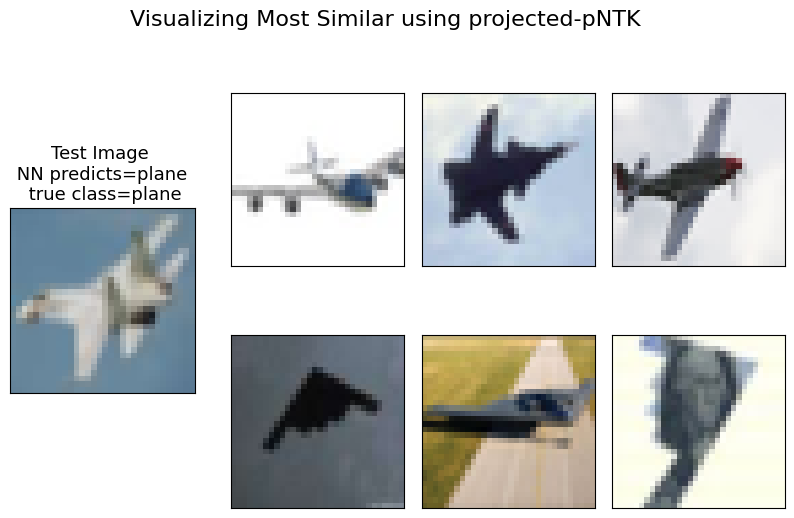

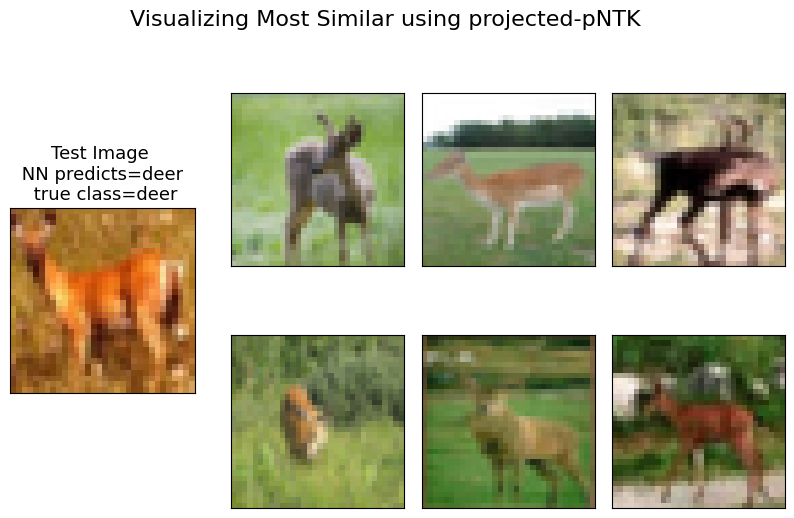

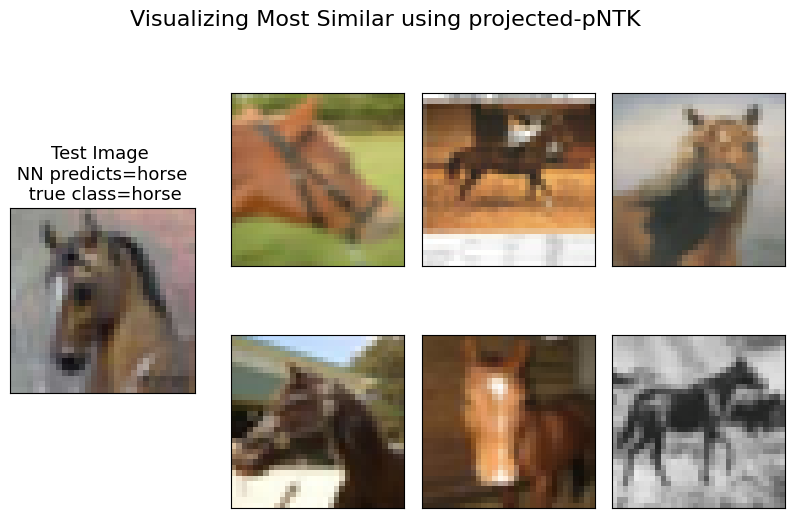

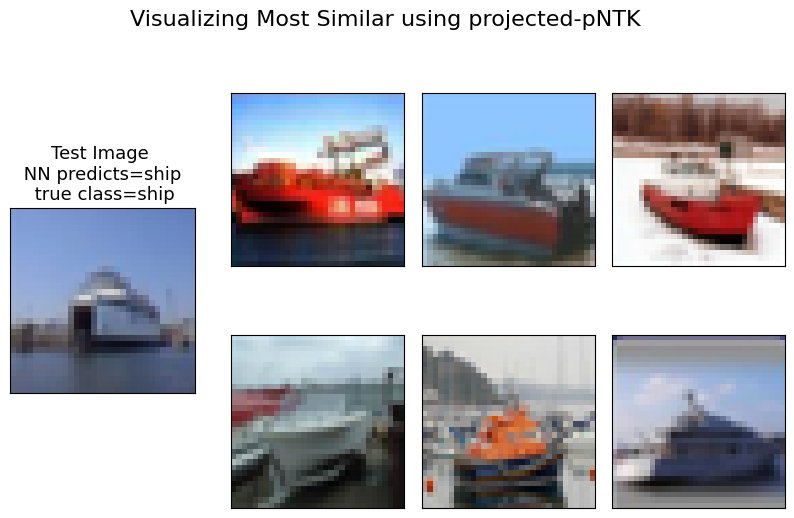

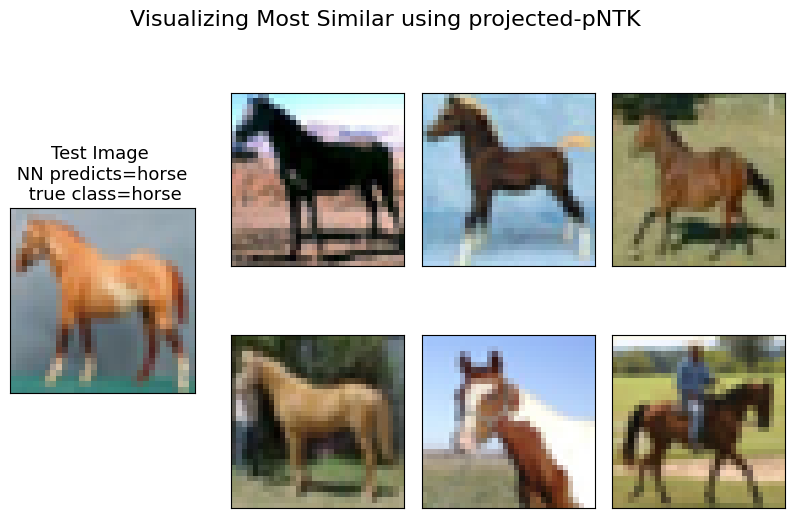

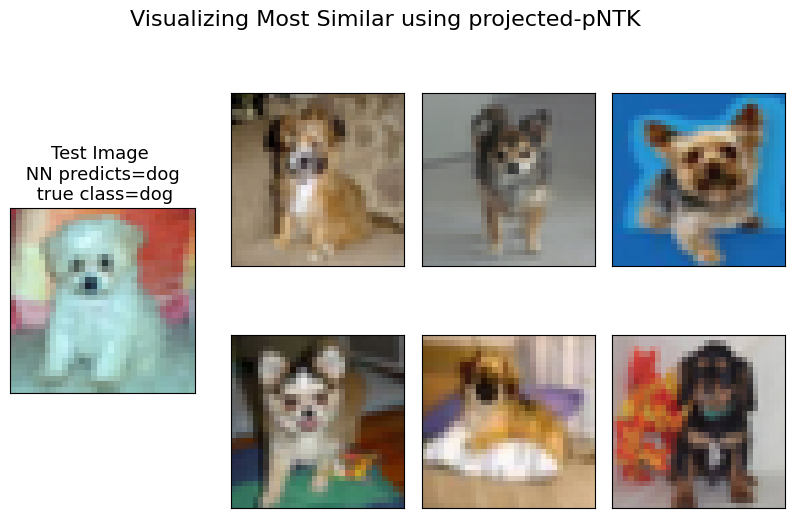

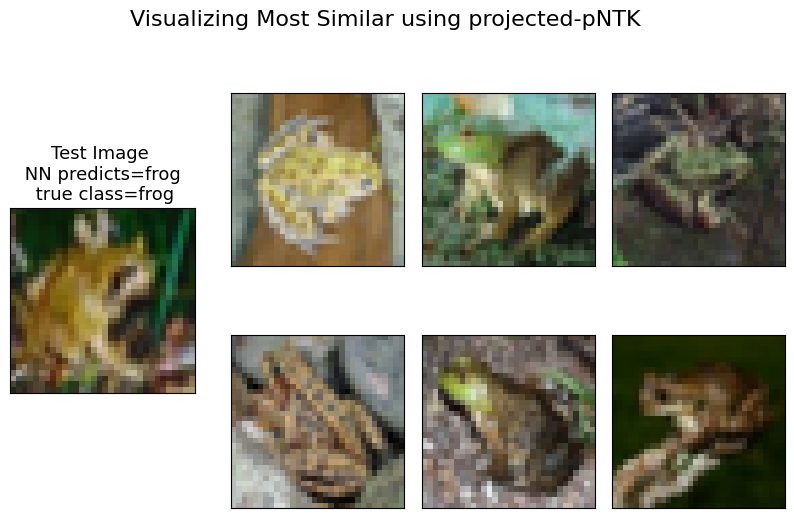

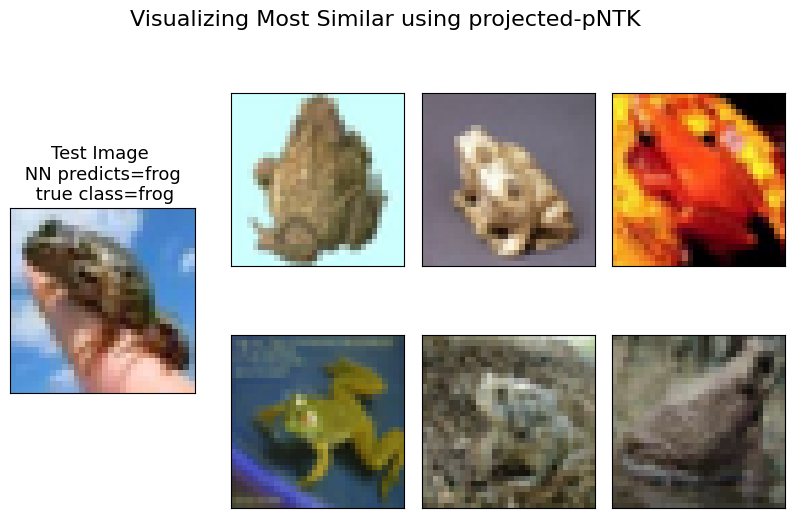

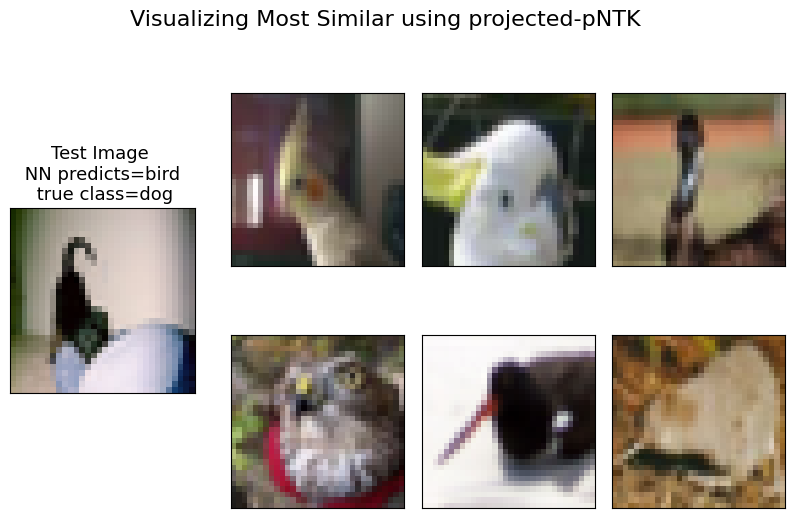

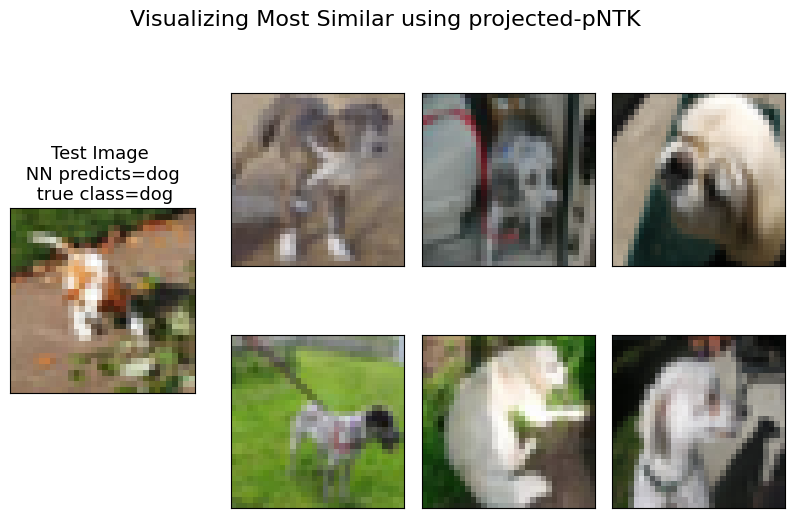

In [18]:
for TEST_INDEX in range(10,1010,100):
    CompareAllViz(TEST_INDEX,K1,'pNTK')

# Neat! But these don't neccessarily speak to me as conceptually similar to the original image... maybe we should contrast this to the proj-trNTK?

In [19]:
SAVEPATH2='/rcfs/projects/task0_pmml/proj_trNTK/test_quick2/'

In [20]:
traker = TRAKer(model=model,
                task='trNTK', #also available 'trNTK'
                save_dir = SAVEPATH2, #unique save for this experiment run
                train_set_size=len(combined_loader.dataset), #length of dataloader
                num_classes=10, #!!! now that we are computing trNTK, we need to specify number of output neurons.
                proj_dim=512*6, #K, for cuda must be multiple of 512, we chose 512*20 for results in paper
                proj_max_batch_size=16, #choose one of [8,16,32] for cuda. affects max memory load
                use_half_precision=False) #default is True

                             Report any issues at https://github.com/MadryLab/trak/issues
INFO:STORE:Existing model IDs in /rcfs/projects/task0_pmml/proj_trNTK/test_quick2: [0]
INFO:STORE:No model IDs in /rcfs/projects/task0_pmml/proj_trNTK/test_quick2 have been finalized.
INFO:STORE:No existing TRAK scores in /rcfs/projects/task0_pmml/proj_trNTK/test_quick2.


### this will now be the same as before-- internally, TRAK runs a for loop over number of classes, so the trNTK will not scale with very large number of classes. 

In [21]:
# TRAKer loads the provided checkpoint and also associates
# the provided (unique) model_id with the checkpoint.
traker.load_checkpoint(ckpt, model_id=0)

for batch in tqdm(combined_loader):
    batch = [x.cuda() for x in batch]
    #technically, our trNTK and pNTK modeloutput functions do not utilize
    #the labels. Could pass a tensor of all zeros and wouldn't matter
    batch[1] = torch.tensor(batch[1],dtype=torch.long)#converts float to int.
    # TRAKer computes features corresponding to the batch of examples,
    # using the checkpoint loaded above.
    traker.featurize(batch=batch, num_samples=batch[0].shape[0])
    
#took 26min on V100 GPU

  0%|                                                                                            | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_246728/2779430736.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch[1] = torch.tensor(batch[1],dtype=torch.long)#converts float to int.
100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:00<00:00, 1863.59it/s]


### but we must manually combine the NTK from each logit together; easily done in this case

In [22]:
trNTK = 0
for i in range(10):
    A = torch.from_numpy(np.load(os.path.join(SAVEPATH2,f'0/grads_{i}.mmap'))).cuda()
    #NOTE: for the trNTK, we would simply sum over the grads{}.npy files generated representing each output. 
    trNTK += torch.matmul(A,A.T).cpu()

#and extract trNTK versions of the kernels


In [23]:
#K0 = train-x-train kernel
trK0 = trNTK[10_000::,10_000::].cpu().numpy()

#K1 = test-x-train kernel
trK1 = trNTK[0:10_000,10_000::].cpu().numpy()

#K2 = text-x-test kernel
trK2 = trNTK[0:10_000,0:10_000].cpu().numpy()

#Now normalize-- every value will be in [-1,1] and we can interpret geometrically as cosine(angle) 
#between the projected jacobian vectors
trK1 = trK1 / (np.sqrt(np.diagonal(trK0))[None,:]) / (np.sqrt(np.diagonal(trK2))[:,None])
trK0 = trK0 / np.sqrt(np.diagonal(trK0))[:,None] / np.sqrt(np.diagonal(trK0))[None,:]

### we are now ready to visualize using our proj-trNTK kernel!

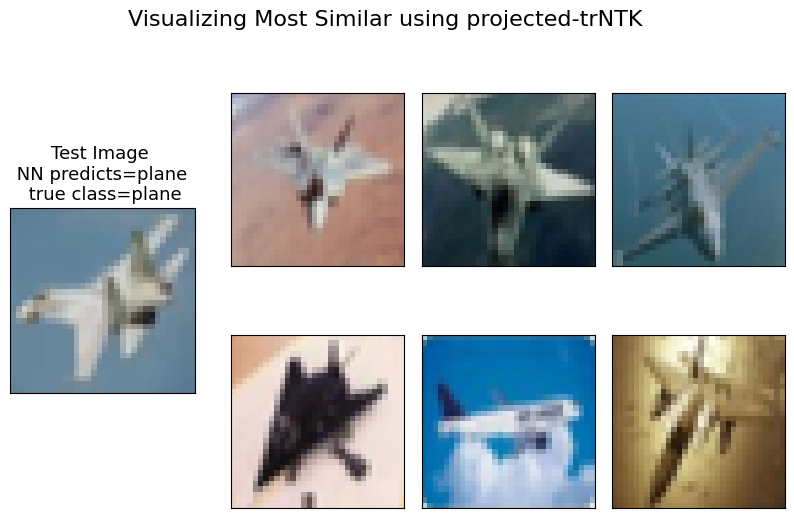

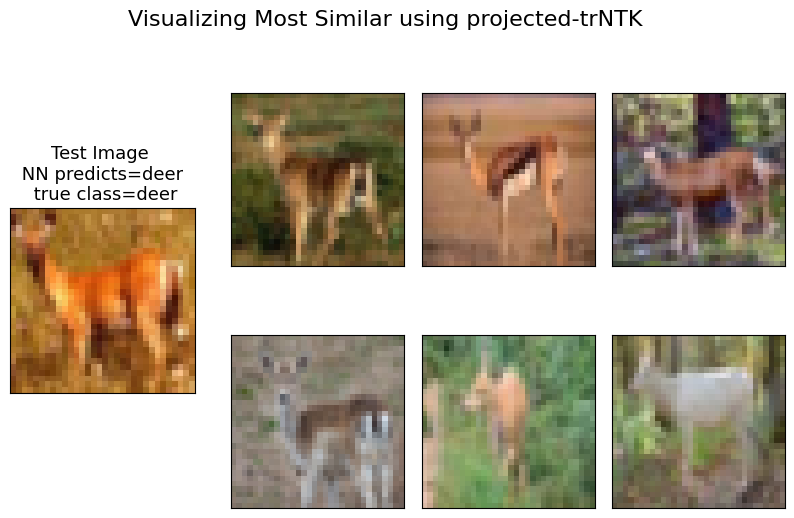

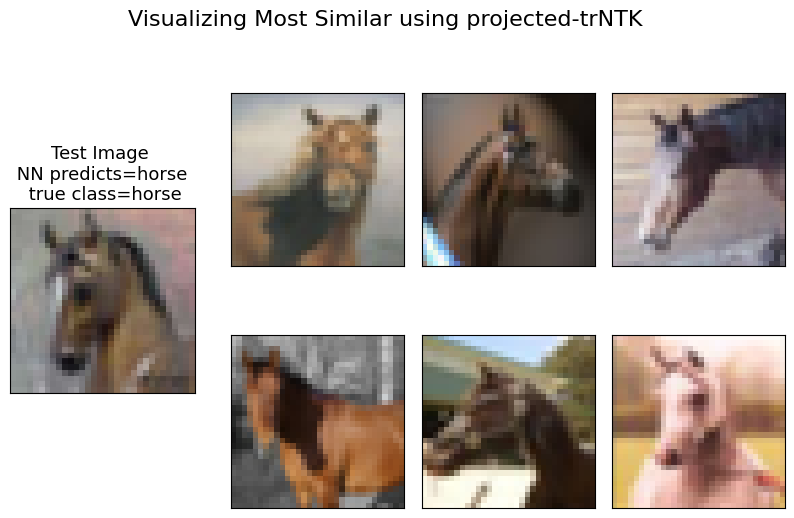

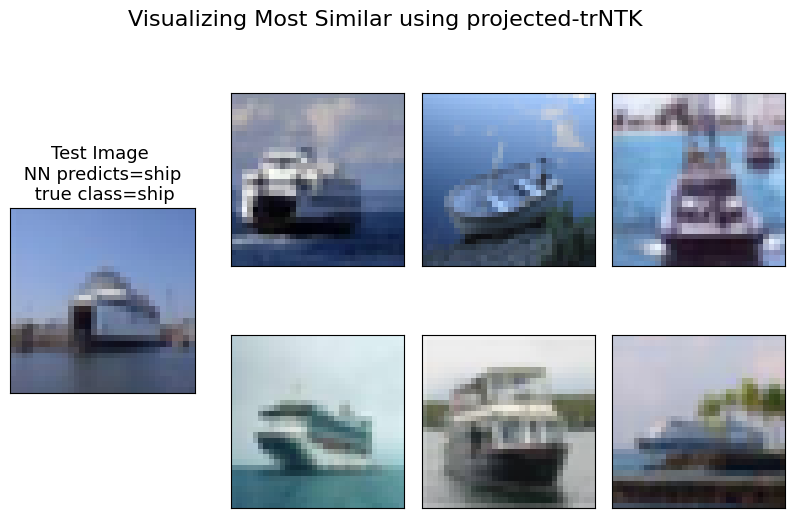

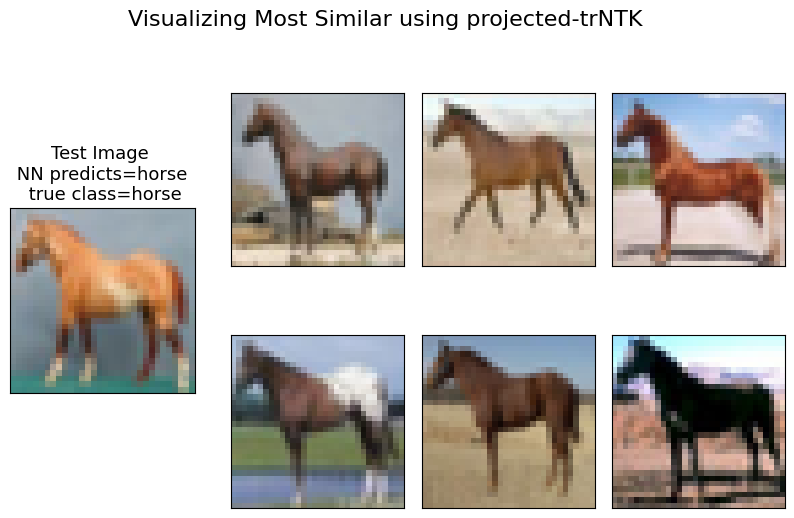

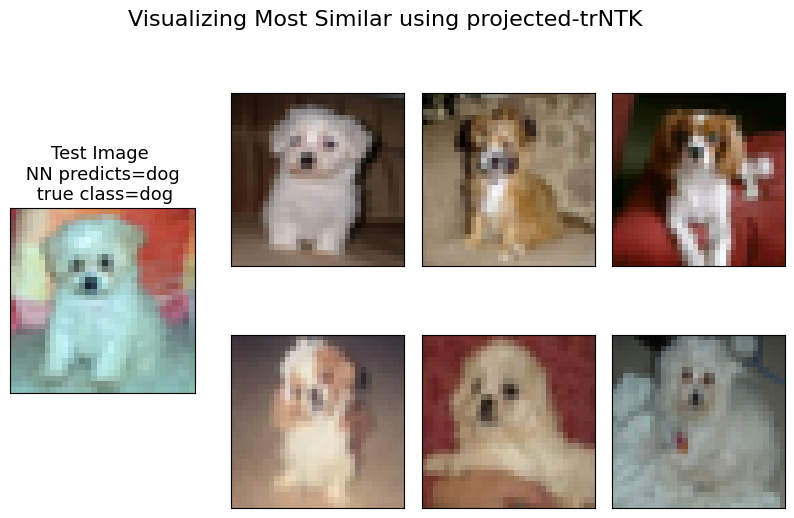

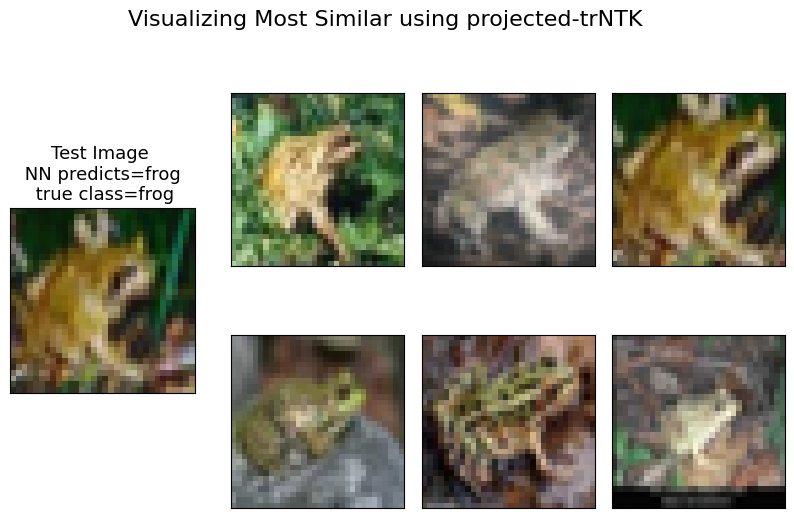

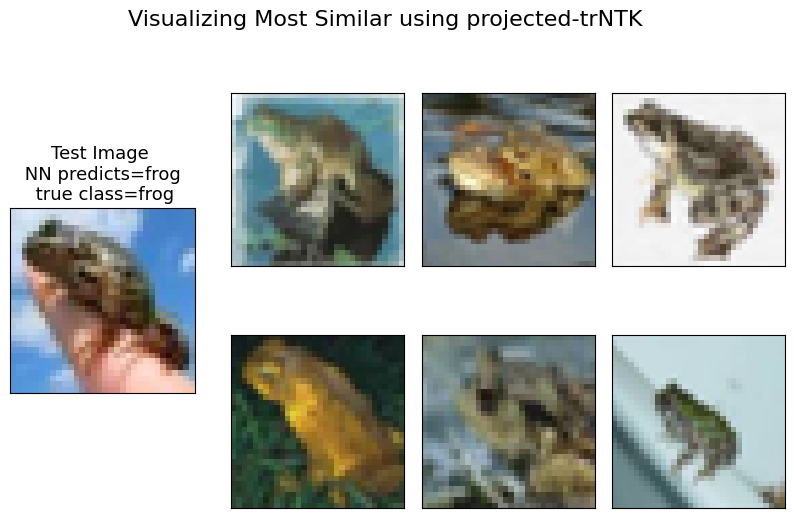

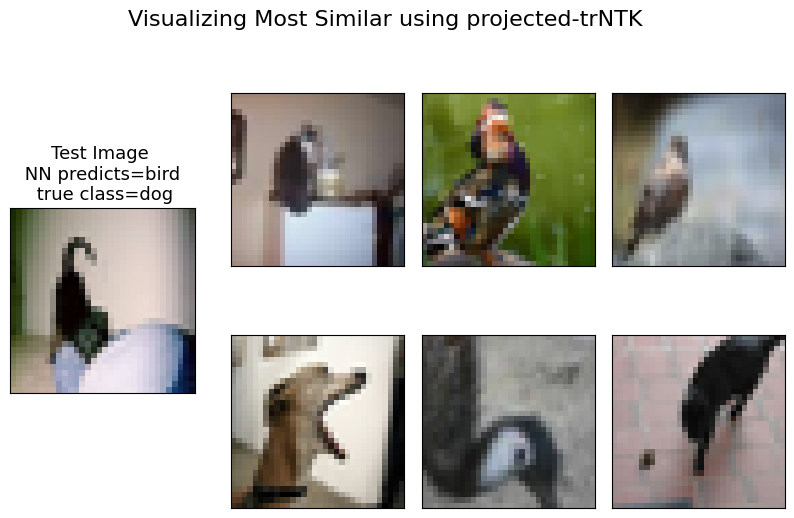

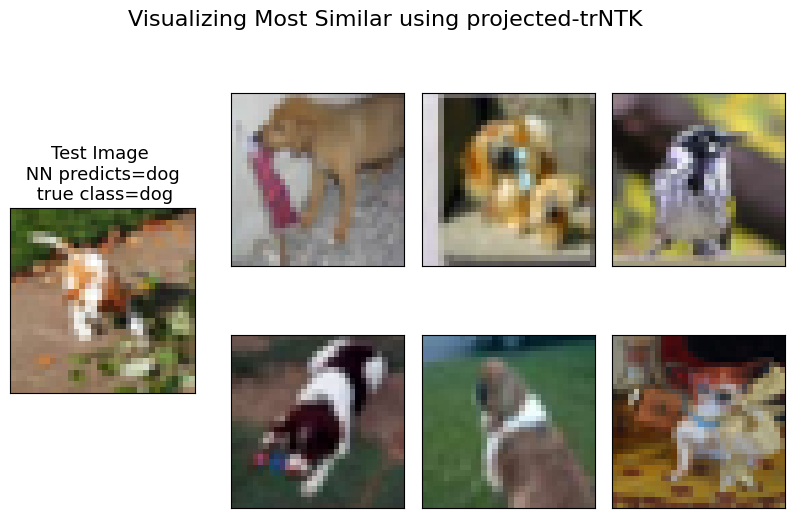

In [24]:
for TEST_INDEX in range(10,1010,100):
    CompareAllViz(TEST_INDEX,trK1,'trNTK')